# Discrétisation du problème $ -\Delta u = f$ 

On s'intéresse à la discrétisation du problème suivante : 

$$ -\Delta u = f$$ 

sur l'intervalle $ \Omega = [0,1]\times [0,1]$ où $u = 0$ sur $ \partial \Omega$. 

La fonction $f$ est définie de la manière suivante : 

$$ f(x_1,x_2) = 6*(1-3*x_1+2*x_1^2)*((x_2-1)^3)*x_2 + 6*(1-3*x_2+2*x_2^2)*((x_1-1)^3)*x_1$$. 

On connait l'expression de u qui est la suivante : 

$$ u(x_1,x_2) = x_1*x_2*((x_1-1)^3)*((x_2-1))^3$$

Le but de ce rapport est de retrouver $u$ par différences finies. Pour cela nous écrirons une fonction qui retournera la matrice de discrétisation du Laplacien, nous résolverons ensuite le système et comparerons la solution approchée à celle exacte connue.

On commence par importer les packages dont nous avons besoin.

In [10]:
import numpy as np
import scipy.sparse as sparse   # Algèbre linéaire creuse
import matplotlib.pyplot as plt # Pour les graphiques
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D

La fonction suivante permet d'écrire la matrice de la discrétisation du laplacien dans notre cas. On découpe l'intervalle $[0,1]\times[0,1]$ en $N$ intervalles en $x$ et en $y$. Elle retourne une matrice de taille $(N+1)\times(N+1)$.

In [14]:
def matrix_lap(N):
    """Retourne une matrice qui discrétise le laplacien de u dans le domaine Omega = [xmin,xmax,ymin,ymax], 
    découpé en N intervalles en x et y. La matrice finale est une matrice scipy.sparse CSR matrix. 
    Cette matrice est de taille (N+1)*(N+1)"""

    h = 1./N
    h2 = h*h

    #On note les inconnues de 0 à Nx suivant x et 0 à Ny suivant y. La taille du problème est donc (Nx+1)*(Ny+1).

    #Cela correspond à x_i = i*h et y_j = j*h et la numérotation (i,j) --> k := (N+1)*j+i.

    taille = (1+N)*(1+N)

    diags = np.zeros((5,taille))

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = -4./h2
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = 1./h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = 1./h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = 1./h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = 1./h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csr")

    return A

Munis de cette fonction, il ne nous reste plus qu'à résoudre le problème en suivante l'ordre de numérotation des sommets qui est le suivant : $k = i + (N+1)\times j, \quad i = 0,\ldots,N, \quad j = 0,\ldots,N$

Voyons ce que nous retourne la fonction matrix_lap pour N = 2 et N = 3.

In [16]:
print(matrix_lap(2).todense())

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  0.   4.   0.   4. -16.   4.   0.   4.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]]


In [17]:
print(matrix_lap(3).todense())

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   9.   0.   0.   9. -36.   9.   0.   0.   9.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   9.   0.   0.   9. -36.   9.   0.   0.   9.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   9.   0.   0.   9. -36.   9.   0.   0.   9.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   9.   0.   0.   9. -36.   9.   0.   0.
    9.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0

Par suite, nous écrivons le code pour la fonction $f$ et notre solution exacte $u$

In [18]:
def f(x1,x2):
    return 6.*(1.-3.*x1+2.*x1**2)*((x2-1.)**3)*x2 + 6.*(1.-3.*x2+2.*x2**2)*((x1-1.)**3)*x1

def u(x1,x2):
    return x1*x2*((x1-1.)**3)*((x2-1))**3

On va résoudre le problème pour N = 100. On initialise le maillage en $x$ et $y$ comme suit :

In [41]:
N = 100

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

On écrit la fonction qui sort la solution approchée du problème.

In [42]:
def sol_disc(N):
    
    F = np.zeros((N+1)*(N+1))   #Allocation mémoire de f

    for i in np.arange(1,N):    #(1,N) car on veut que ce soit 0 sur les bords
        for j in np.arange(1,N):
            k = i + j*(N+1)
            F[k] = f(x[i],y[j])

    U = np.zeros((N+1)*(N+1))   #matrice pour la solution
    A = matrix_lap(N)
        
    U = spsolve(A,F)
    
    return U


Et on affiche finalement la solution 

Text(0.5, 0.92, 'Solution discrétisée')

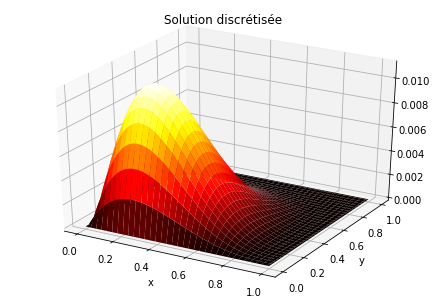

In [43]:
U = sol_disc(N)
fig = plt.figure(1)
ax = Axes3D(fig)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y, U.reshape((N+1,N+1)), cmap='hot')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution discrétisée")

On va la comparer avec le graphique de la solution exacte par la fonction suivante : 

Text(0.5, 0.92, 'Solution exacte')

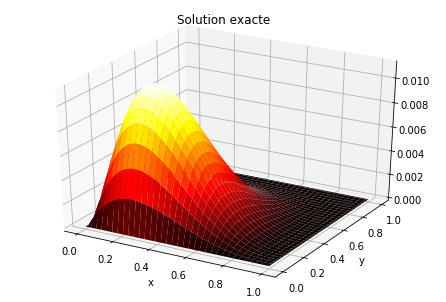

In [44]:
def sol_exacte(N):
    V = np.zeros((N+1)*(N+1))   #Allocation mémoire sol exacte
    
    for i in np.arange(N+1):
        for j in np.arange(N+1):
            k = i + j*(N+1)
            V[k] = u(x[i],y[j])
    
    return V

V = sol_exacte(N)

fig2 = plt.figure(2)
ax = Axes3D(fig2)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,V.reshape((N+1,N+1)),cmap = 'hot')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution exacte")

On peut remarquer que les graphes sont très ressemblants, ce qui est une bonne nouvelle. Cependant, nous allons calculer l'erreur entre la solution approchée et exacte afin de vérifier la justesse de notre discrétisation.

In [45]:
def erreur_du_cours(A,E,N):
    return np.sum((E-A)**2)/((N+1)**2)

err1 = erreur_du_cours(U,V,N)
print("{:8s} {:12s}".
    format("Taille", "Erreur demandée"))
print("{:8d} {:12.5e}".
    format((N+1)*(N+1), err1))

Taille   Erreur demandée
   10201  9.12832e-13


In [46]:
def erreur_abs(A,E,N):
    return np.max(np.abs(E - A))

err2 = erreur_abs(U,V,N)
print("{:8s} {:12s}".
    format("Taille", "Erreur absolue"))
print("{:8d} {:12.5e}".
    format((N+1)*(N+1), err2))

Taille   Erreur absolue
   10201  1.85769e-06
